In [12]:
from json import loads
from argparse import ArgumentParser
from numpy import float16, short

from dataset.sample import Sample
from dataset.utils import store_single_hdf5

config = './dataset/config.json'

with open(config) as f:
    config = loads(f.read())
    
s = Sample(config, 'default', 300)
x = s.simres #.astype(short).reshape(-1)
y = s.params_norm.astype(float16).reshape(-1)

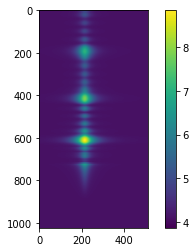

In [13]:
plt.imshow(np.log(x.reshape(1024,512)))
plt.colorbar()

In [9]:
with open('logs/hostname_5077872.out') as file:
    lines = file.readlines()
    train11 = [float(line.rstrip().split(' ')[-5][:-1]) for line in lines if line[0] == '[']
    val11 = [float(line.rstrip().split(' ')[-1]) for line in lines if line[0] == '[']
    
with open('logs/hostname_5074272.out') as file:
    lines = file.readlines()
    train3 = [float(line.rstrip().split(' ')[-5][:-1]) for line in lines if line[0] == '[']
    val3 = [float(line.rstrip().split(' ')[-1]) for line in lines if line[0] == '[']

In [5]:
import matplotlib.pyplot as plt
import numpy as np

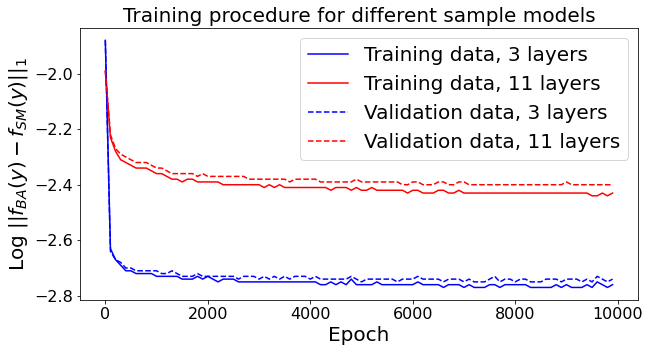

In [11]:
plt.figure(figsize = [10,5])
plt.plot(np.arange(0,10000,100),train3[::20], label = 'Training data, 3 layers', c = 'blue')
plt.plot(np.arange(0,10000,100),train11[::20], label = 'Training data, 11 layers', c = 'red')
plt.plot(np.arange(0,10000,100),val3[::20], label = 'Validation data, 3 layers', c = 'blue', linestyle = '--')
plt.plot(np.arange(0,10000,100),val11[::20], label = 'Validation data, 11 layers', c = 'red', linestyle = '--')
plt.ylabel(r'Log $||f_{BA}(y) - f_{SM}(y)||_1$', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.title('Training procedure for different sample models', fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize = 20)

## Surrogate model

In [3]:
%run train_surrogate.py --augmentation 1 --train 0 --window_size 11 5 --distance 'l1_ssim' --model 'fcnet' --in_shape 128 16 --n_samples 10 --n_layers 3 --batch_size 9 --n_epochs 1000 --minmax 1 --log 1 --data_path '/bigdata/hplsim/aipp/Maksim/BA_simulation/layer_3/'

100%|██████████| 1/1 [00:00<00:00, 535.33it/s]



 Data loaders created


In [8]:
import torch
model.load_state_dict(torch.load('./saved_models/fcnet___1_1_0_l2_3_128_16'))

<All keys matched successfully>

In [9]:
xs, ys = next(iter(loaders['train']))
x_pred = model(ys.cuda()).cpu().detach()

In [10]:
from torchvision.utils import make_grid
grid_img = make_grid(xs.unsqueeze(1)[:], nrow=3).cpu().detach()
grid_img_pred = make_grid(x_pred[:], nrow=3).cpu().detach()

(-0.5, 55.5, 391.5, -0.5)

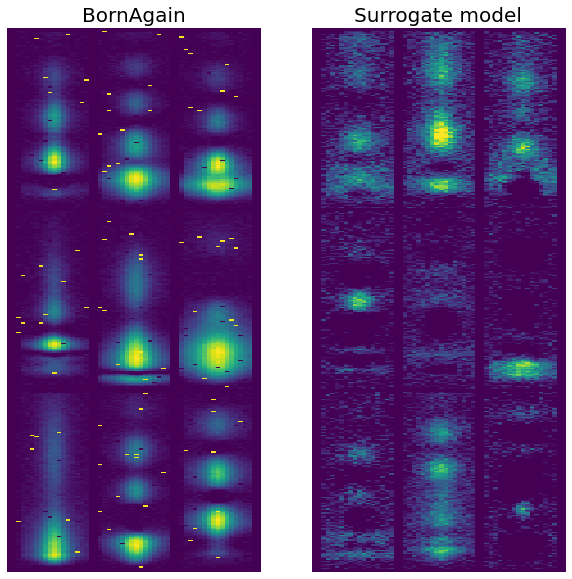

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10,10])

plt.subplot(1,2,1)
plt.title('BornAgain', fontsize = 20)
plt.imshow(grid_img[0], vmin = 0, vmax = 1, aspect = 'auto', interpolation='nearest')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Surrogate model', fontsize = 20)
plt.imshow(grid_img_pred[1], vmin = 0, vmax = 1, aspect = 'auto', interpolation='nearest')
plt.axis('off')

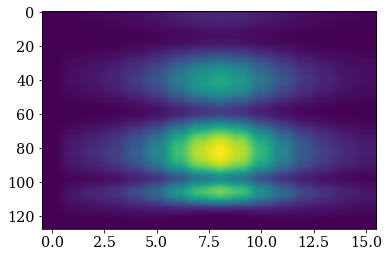

In [126]:
x_t, y_t = loaders['val'].dataset[3]
plt.imshow(x_t, aspect = 'auto')

## Neighborhood of a point

In [261]:
from torchmetrics.functional import structural_similarity_index_measure as ssim
import torch

In [248]:
def neighborhood_y(y, n, dim, width):
    dim = torch.tensor(dim)
    y_n = y.unsqueeze(0).repeat(n,1)
    noise = torch.rand(n, len(dim)) - 0.5
    y_n[:, dim] = torch.clip(y[dim] + width*noise, 0, 1)
    return y_n

def eps_neighborhood(model, y, x_t,  distance):
    pred = model(y.cuda()).cpu().detach()
    true = x_t.unsqueeze(0)
    if distance == 'l1':
        return 1 - (pred - true).abs().mean((-1,-2))
    elif distance == 'l2':
        return 1 - (pred - true).square().sqrt().mean((-1,-2))
    elif distance == 'ssim':
        return ssim(pred, true.repeat(n,1,1).unsqueeze(1), reduction='none')
    
def get_best_match(model, y_t, x_t, distance, n):
    y_n = neighborhood_y(y_t, n, dim, 1.5)
    d = eps_neighborhood(model, y_n, x_t, distance = distance)
    y_n[:, dim] = y_n[d.argmax(),dim]
    return model(y_n.cuda()[:1]).cpu().detach()[0,0]

In [249]:
model.load_state_dict(torch.load('./saved_models/fcnet___1_1_0_l1_ssim_3_128_16'))

x_ssim = get_best_match(model, y_t, x_t, 'ssim', 5000)
x_2 = get_best_match(model, y_t, x_t, 'l2', 5000)
x_1 = get_best_match(model, y_t, x_t, 'l1', 5000)

Text(0.5, 1.0, '$min_X \\: l1(X_{exp}, X)$')

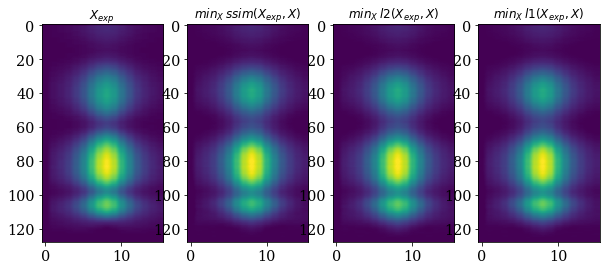

In [250]:
fig, ax = plt.subplots(1,4, figsize = [10,4])
ax[0].imshow(x_t, aspect = 'auto', vmin = 0, vmax = 1)
ax[0].set_title(r'$X_{exp}$')
ax[1].imshow(x_ssim, aspect = 'auto', vmin = 0, vmax = 1)
ax[1].set_title(r'$min_X \: ssim(X_{exp}, X)$')
ax[2].imshow(x_2, aspect = 'auto', vmin = 0, vmax = 1)
ax[2].set_title(r'$min_X \: l2(X_{exp}, X)$')
ax[3].imshow(x_1, aspect = 'auto', vmin = 0, vmax = 1)
ax[3].set_title(r'$min_X \: l1(X_{exp}, X)$')

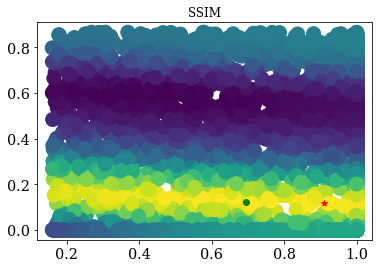

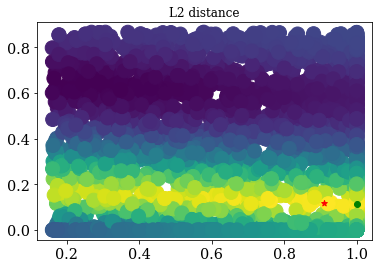

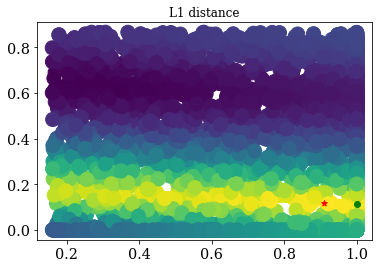

In [270]:
dim = [7,8]
y_n = neighborhood_y(y_t, n, dim, 1.5)
model.load_state_dict(torch.load('./saved_models/fcnet___1_1_0_l1_3_128_16'))

dist = eps_neighborhood(model, y_n, x_t, distance = 'ssim')
plt.scatter(*y_n[:,dim].T, c = dist, s = 200)
plt.scatter(*y_t[dim], c = 'red', marker="*")
plt.scatter(*y_n[dist.argmax(), dim], c = 'green', marker="o")
plt.title('SSIM')

plt.show()

dist = eps_neighborhood(model, y_n, x_t, distance = 'l2')
plt.scatter(*y_n[:,dim].T, c = dist, s = 200)
plt.scatter(*y_t[dim], c = 'red', marker="*")
plt.scatter(*y_n[dist.argmax(), dim], c = 'green', marker="o")
plt.title('L2 distance')

plt.show()

dist = eps_neighborhood(model, y_n, x_t, distance = 'l1')
plt.scatter(*y_n[:,dim].T, c = dist, s = 200)
plt.scatter(*y_t[dim], c = 'red', marker="*")
plt.scatter(*y_n[dist.argmax(), dim], c = 'green', marker="o")
plt.title('L1 distance')

plt.show()

## Loss influence

In [77]:
model_l1 = FCNet(6*args.n_layers, name).cuda()
model_l1.load_state_dict(torch.load('./saved_models/fcnet___1_1_0_l1_3_128_16'))

model_ss = FCNet(6*args.n_layers, name).cuda()
model_ss.load_state_dict(torch.load('./saved_models/fcnet___1_1_0_l1_ssim_3_128_16'))

<All keys matched successfully>

In [78]:
x_ssim = get_best_match(model_ss, y_t, x_t, 'ssim'), get_best_match(model_l1, y_t, x_t, 'ssim')
x_2 = get_best_match(model_ss, y_t, x_t, 'l2'), get_best_match(model_l1, y_t, x_t, 'l2')
x_1 = get_best_match(model_ss, y_t, x_t, 'l1'), get_best_match(model_l1, y_t, x_t, 'l1')

SSIM-optimized model


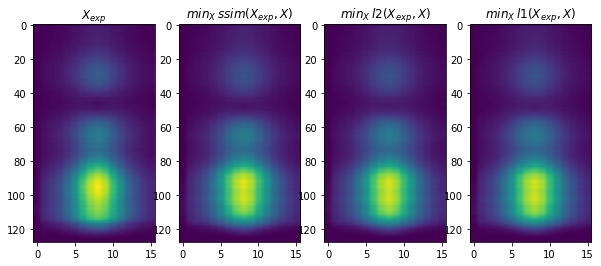

L1-optimized model


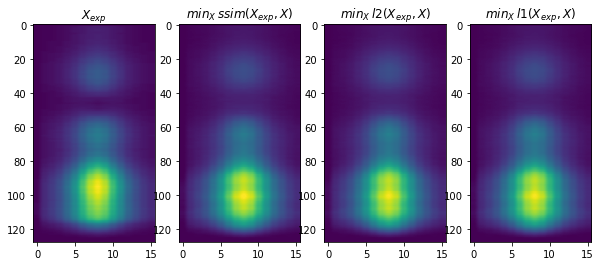

In [82]:
print('SSIM-optimized model')

fig, ax = plt.subplots(1,4, figsize = [10,4])
ax[0].imshow(x_t, aspect = 'auto', vmin = 0, vmax = 1)
ax[0].set_title(r'$X_{exp}$')
ax[1].imshow(x_ssim[0], aspect = 'auto', vmin = 0, vmax = 1)
ax[1].set_title(r'$min_X \: ssim(X_{exp}, X)$')
ax[2].imshow(x_2[0], aspect = 'auto', vmin = 0, vmax = 1)
ax[2].set_title(r'$min_X \: l2(X_{exp}, X)$')
ax[3].imshow(x_1[0], aspect = 'auto', vmin = 0, vmax = 1)
ax[3].set_title(r'$min_X \: l1(X_{exp}, X)$')

plt.show()
print('L1-optimized model')

fig, ax = plt.subplots(1,4, figsize = [10,4])
ax[0].imshow(x_t, aspect = 'auto', vmin = 0, vmax = 1)
ax[0].set_title(r'$X_{exp}$')
ax[1].imshow(x_ssim[1], aspect = 'auto', vmin = 0, vmax = 1)
ax[1].set_title(r'$min_X \: ssim(X_{exp}, X)$')
ax[2].imshow(x_2[1], aspect = 'auto', vmin = 0, vmax = 1)
ax[2].set_title(r'$min_X \: l2(X_{exp}, X)$')
ax[3].imshow(x_1[1], aspect = 'auto', vmin = 0, vmax = 1)
ax[3].set_title(r'$min_X \: l1(X_{exp}, X)$')
plt.show()

Text(0.5, 1.0, 'Color encodes dist(SM(y), $X_{ref}$)')

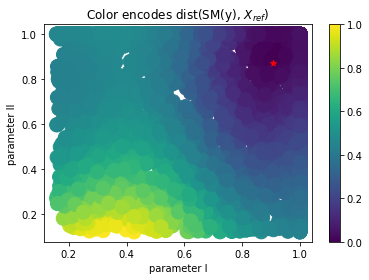

In [95]:
plt.scatter(*y_n[:,dim].T, c = 1 - eps_neighborhood(model_ss, y_n, x_t, distance = 'l1'), s = 200)
plt.scatter(*y_t[dim], c = 'red', marker="*")
plt.xlabel('parameter I')
plt.ylabel('parameter II')
plt.colorbar()
plt.title(r'Color encodes dist(SM(y), $X_{ref}$)')

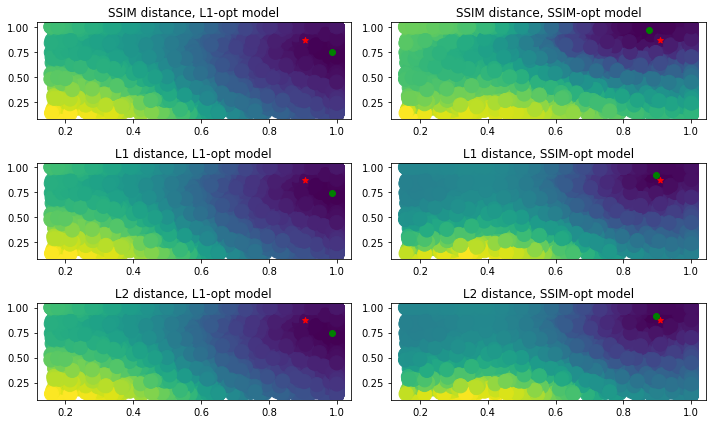

In [113]:
fig, ax = plt.subplots(3,2, figsize = [10,6])
y_n = neighborhood_y(y_t, n, dim, 1.5)

dist = 1 - eps_neighborhood(model_l1, y_n, x_t, distance = 'l1')
ax[0,0].scatter(*y_n[:,dim].T, c = dist, s = 200)
ax[0,0].scatter(*y_t[dim], c = 'red', marker="*")
ax[0,0].scatter(*y_n[dist.argmin(), dim], c = 'green', marker="o")
ax[0,0].set_title('SSIM distance, L1-opt model')

dist = 1 - eps_neighborhood(model_ss, y_n, x_t, distance = 'ssim')
ax[0,1].scatter(*y_n[:,dim].T, c = dist, s = 200)
ax[0,1].scatter(*y_t[dim], c = 'red', marker="*")
ax[0,1].scatter(*y_n[dist.argmin(), dim], c = 'green', marker="o")
ax[0,1].set_title('SSIM distance, SSIM-opt model')

dist = 1 - eps_neighborhood(model_l1, y_n, x_t, distance = 'l1')
ax[1,0].scatter(*y_n[:,dim].T, c = dist, s = 200)
ax[1,0].scatter(*y_t[dim], c = 'red', marker="*")
ax[1,0].scatter(*y_n[dist.argmin(), dim], c = 'green', marker="o")
ax[1,0].set_title('L1 distance, L1-opt model')

dist = 1 - eps_neighborhood(model_ss, y_n, x_t, distance = 'l1')
ax[1,1].scatter(*y_n[:,dim].T, c = dist, s = 200)
ax[1,1].scatter(*y_t[dim], c = 'red', marker="*")
ax[1,1].scatter(*y_n[dist.argmin(), dim], c = 'green', marker="o")
ax[1,1].set_title('L1 distance, SSIM-opt model')

dist = 1 - eps_neighborhood(model_l1, y_n, x_t, distance = 'l2')
ax[2,0].scatter(*y_n[:,dim].T, c = dist, s = 200)
ax[2,0].scatter(*y_t[dim], c = 'red', marker="*")
ax[2,0].scatter(*y_n[dist.argmin(), dim], c = 'green', marker="o")
ax[2,0].set_title('L2 distance, L1-opt model')

dist = 1 - eps_neighborhood(model_ss, y_n, x_t, distance = 'l2')
ax[2,1].scatter(*y_n[:,dim].T, c = dist, s = 200)
ax[2,1].scatter(*y_t[dim], c = 'red', marker="*")
ax[2,1].scatter(*y_n[dist.argmin(), dim], c = 'green', marker="o")
ax[2,1].set_title('L2 distance, SSIM-opt model')

fig.tight_layout()

plt.show()

## Distribution

In [162]:
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import seaborn as sns

import torch
model.load_state_dict(torch.load('./saved_models/fcnet___1_1_0_l1_ssim_3_128_16'))

<All keys matched successfully>

In [164]:
y_s_ = []
diff_s = []
for i in tqdm(range(len(loaders['train'].dataset))):
    x, y = loaders['train'].dataset[i] # only one sample
    diff_s.append(F.l1_loss(x, x_t).item())
    y_s_.append(np.array(y))
y_s_ = np.array(y_s_)

100%|██████████| 47500/47500 [00:01<00:00, 40313.45it/s]


In [165]:
y_m_d = []
diff_m = []
for i in tqdm(range(len(loaders['train'].dataset))):
    x, y = loaders['train'].dataset[i] # only one sample
    x_m = model(y.unsqueeze(0).cuda()).cpu().detach()
    diff_m.append(F.l1_loss(x_m.squeeze(), x_t).item())
    y_m_d.append(np.array(y))
y_m_d = np.array(y_m_d)

100%|██████████| 47500/47500 [00:15<00:00, 3076.13it/s]


In [166]:
y_s = y_s_[diff_s < np.sort(diff_s)[100]]
y_m = y_m_d[diff_m < np.sort(diff_m)[100]]

In [167]:
from scipy.stats import wasserstein_distance

def wd_batch(x, y):
    xi = []
    for i in range(18):
        xi.append(wasserstein_distance(y_s[:,i], y_m[:,i]))
    return xi

In [168]:
np.mean(wd_batch(y_m, y_s)) # ssim

0.02440571520063612

In [163]:
np.mean(wd_batch(y_m, y_s)) # l1

0.016506305005815295

In [169]:
cols = [['delta', 'beta', 'thickness'], ['roughness', 'hurst', 'corrlen']]

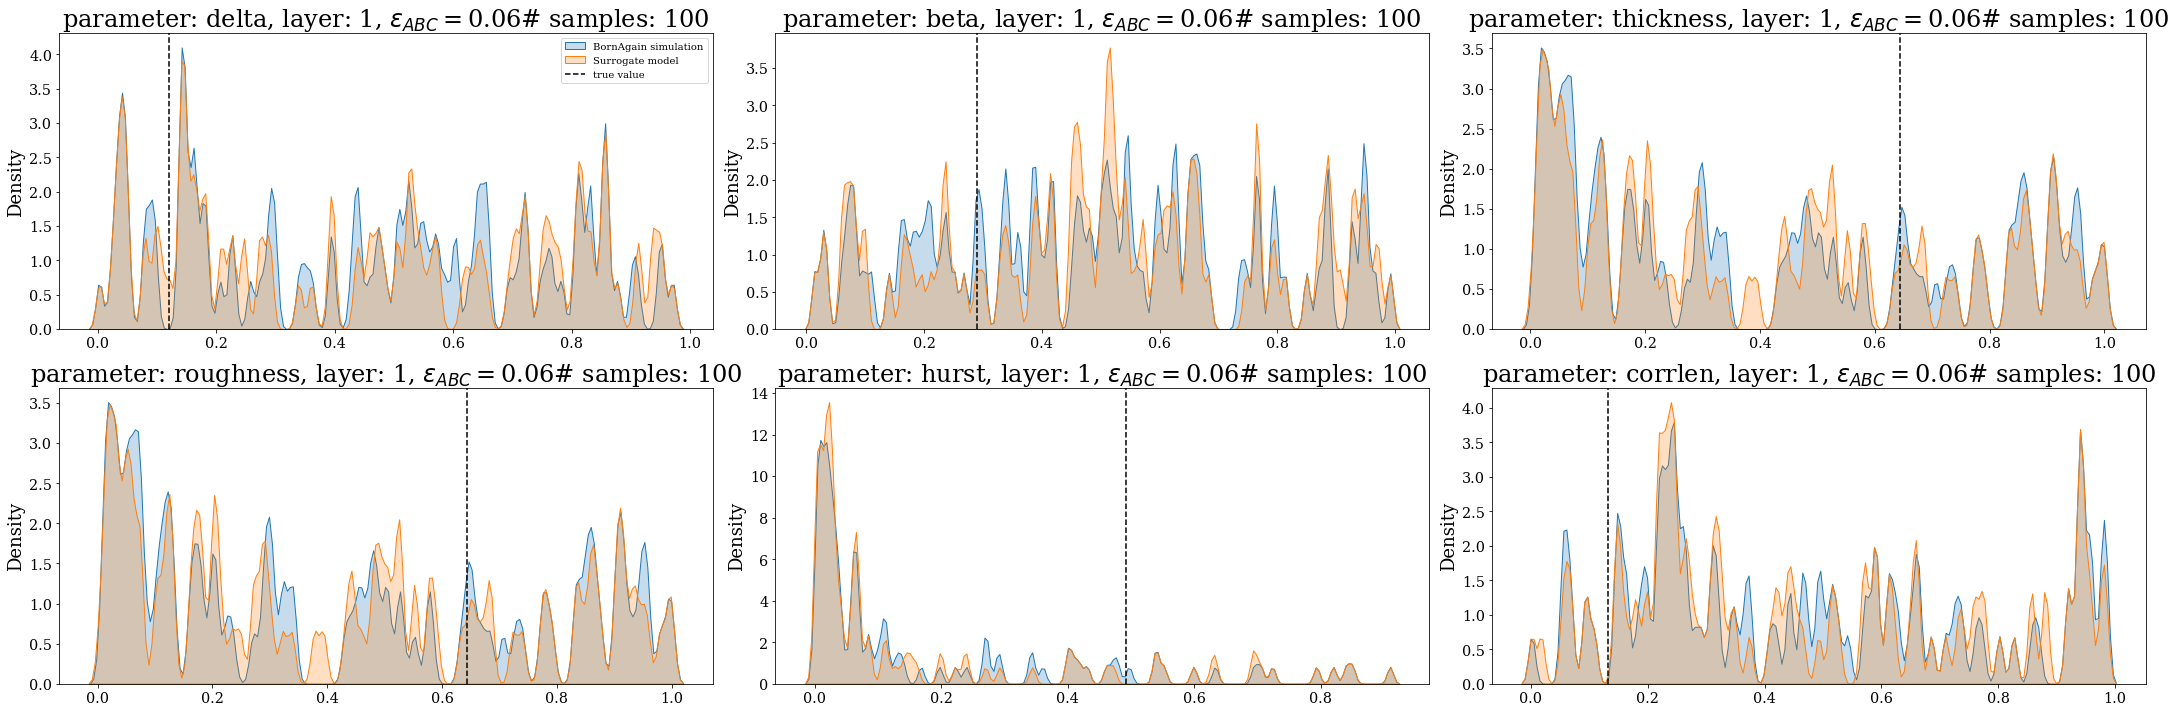

In [171]:
j = 0

fig, ax = plt.subplots(2,3,figsize = [30,10])
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

for i in range(2):
    for k in range(3):
        parameter = cols[i][k]
        layer = 0 + 1

        sns.kdeplot(y_s[:,6*j + i*2+k], fill=True, bw_adjust=0.05, label = 'BornAgain simulation', ax = ax[i,k]);
        sns.kdeplot(y_m[:,6*j + i*2+k], fill=True, bw_adjust=0.05, label = 'Surrogate model', ax = ax[i,k]);
        ax[i,k].axvline(x=y_t[6*j + i*2+k], color='k', linestyle='--', label = 'true value')
        ax[i,k].set_title('parameter: ' + str(parameter) + ', layer: ' + str(j + 1) +  r', $\epsilon_{ABC} = $' + str(np.round(np.sort(diff_s)[100],2)) + '# samples: 100', fontsize=24)
        ax[i,k].set_ylabel('Density', fontsize=18)
        if i == 0 and k == 0:
            ax[i,k].legend()
fig.tight_layout()

## Distribution with expanded search

In [172]:
from tqdm import tqdm
import numpy as np
import torch

model.load_state_dict(torch.load('./saved_models/fcnet___1_1_0_l1_ssim_3_128_16'))

In [235]:
y_m_ = []
diff_m = []
eps = 5e-2
for i in tqdm(range(10000)):
    y = torch.rand([10000,18])
    x_m = model(y.unsqueeze(0).cuda()).cpu().detach()
    mae = (x_m.squeeze() - x_t.unsqueeze(0)).abs().mean((1,2))
    y_eps = y[mae < eps]
    diff = mae[mae < eps]
    if len(y_eps):
        y_m_.append(np.array(y_eps))
        diff_m.append(np.array(diff))
y_m_d = np.concatenate(y_m_)
diff_m = np.concatenate(diff_m)

100%|██████████| 10000/10000 [14:09<00:00, 11.78it/s]


In [236]:
y_s = y_s_[diff_s < np.sort(diff_s)[100]]
y_m = y_m_d[diff_m < np.sort(diff_m)[100]]

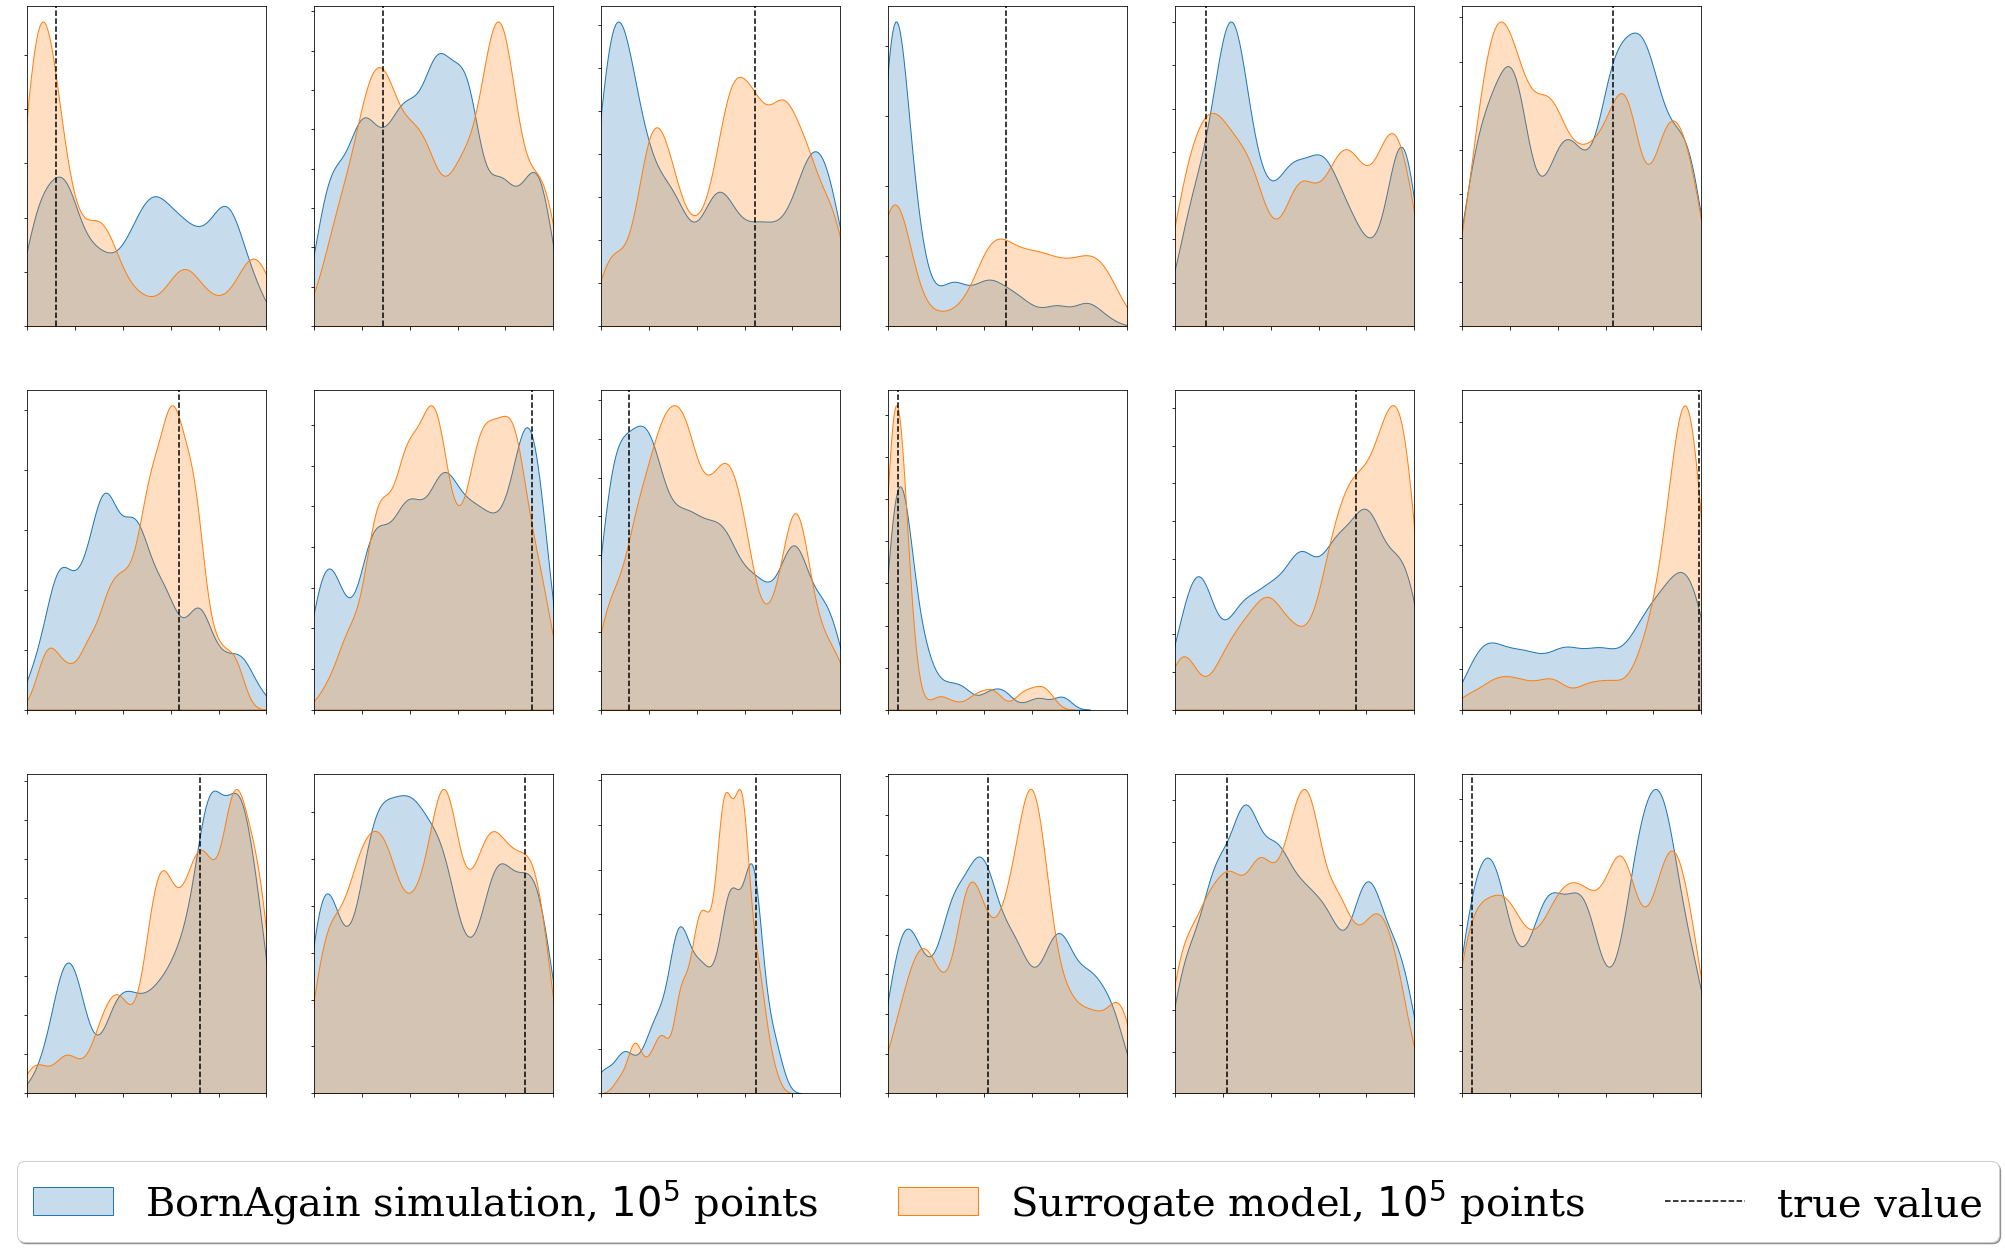

In [237]:
fig, ax = plt.subplots(3,6,figsize = [30,20])

for i in range(3):
    for j in range(6):
        #sns.kdeplot(y_m_.reshape(-1,3,6)[:,i,j], fill=True, bw_adjust=0.5, label = r'Surrogate model, $10^8$ points', ax = ax[i,j]);
        sns.kdeplot(y_s.reshape(-1,3,6)[:,i,j], fill=True, bw_adjust=0.5, label = r'BornAgain simulation, $10^5$ points', ax = ax[i,j]);
        sns.kdeplot(y_m.reshape(-1,3,6)[:,i,j], fill=True, bw_adjust=0.5, label = r'Surrogate model, $10^5$ points', ax = ax[i,j]);
        
        ax[i,j].axvline(x=y_t.reshape(3,6)[i,j], color='k', linestyle='--', label = 'true value')
        ax[i,j].set_xlim(0,1)
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xticklabels([])
        ax[i,j].set_xlabel(' ')
        ax[i,j].set_ylabel(' ')
        
        if i == 0 and j == 3:
            ax[i,j].legend(loc='upper center', bbox_to_anchor=(0.5, -2.55),
          fancybox=True, shadow=True, ncol=4, fontsize = 40)
        
plt.show()

## Distribution with expanded search (eps1 vs eps2)

In [107]:
y_m_1 = []
y_m_2 = []
eps1 = 3e-2
eps2 = 8e-2
for i in tqdm(range(1000)):
    y = torch.rand([10000,18])
    x_m = model(y.unsqueeze(0).cuda()).cpu().detach()
    mae = (x_m.squeeze() - x_t.unsqueeze(0)).abs().mean((1,2))
    y_eps1 = y[mae < eps1]
    y_eps2 = y[mae < eps2]
    if len(y_eps1):
        y_m_1.append(np.array(y_eps1))
    if len(y_eps2):
        y_m_2.append(np.array(y_eps2))
y_m_1 = np.concatenate(y_m_1)
y_m_2 = np.concatenate(y_m_2)

100%|██████████| 1000/1000 [01:23<00:00, 11.92it/s]


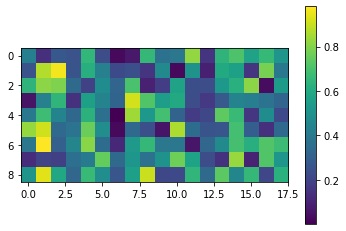

In [138]:
plt.imshow(y_m_1[:9])
plt.colorbar()

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

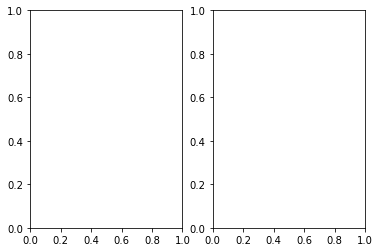

In [146]:
plt.subplots(1,2)

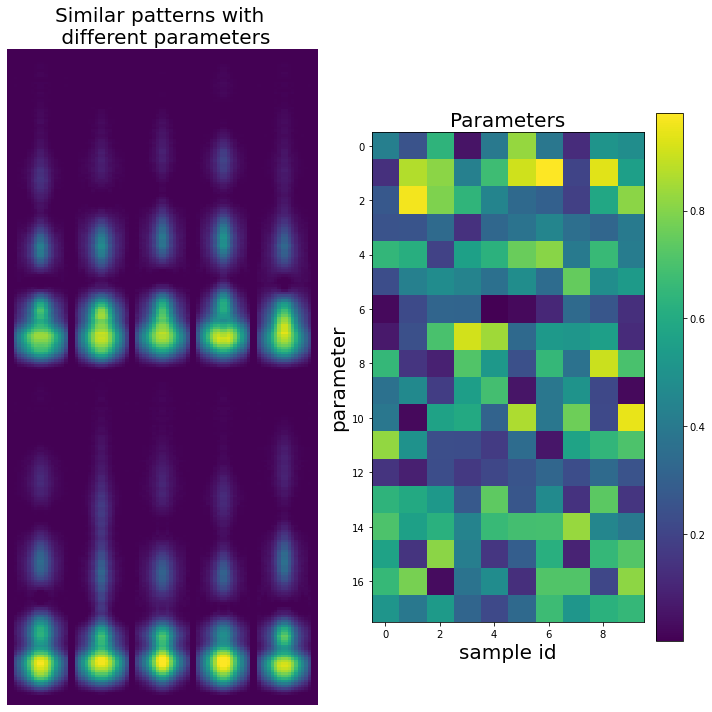

In [174]:
x_rec = model(torch.tensor(y_m_1[:10]).cuda()).cpu().detach()

grid_img = torchvision.utils.make_grid(x_rec, nrow=5).cpu().detach()

fig, ax = plt.subplots(1,2, figsize=[10,10])
ax[0].set_title('Similar patterns with \n different parameters', fontsize = 20)
ax[0].imshow(grid_img[0], vmin = 0, vmax = 1, aspect = 'auto', interpolation='nearest')
ax[0].set_axis_off()

im = ax[1].imshow(y_m_1[:10].T)
ax[1].set_title('Parameters', fontsize = 20)
ax[1].set_xlabel('sample id', fontsize = 20)
ax[1].set_ylabel('parameter', fontsize = 20)
plt.colorbar(im,fraction=0.085, pad=0.04)

fig.tight_layout()

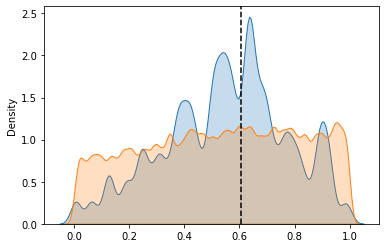

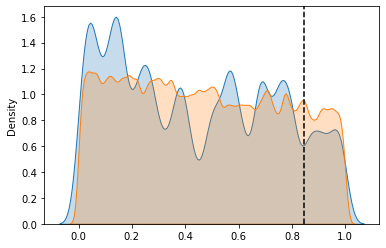

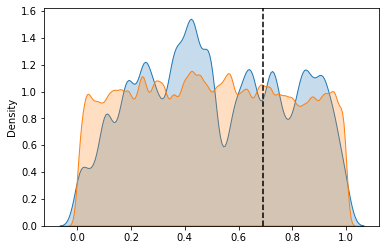

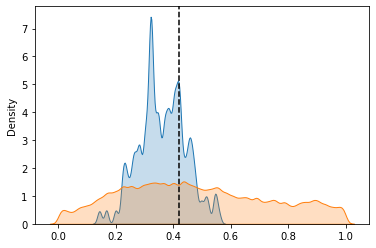

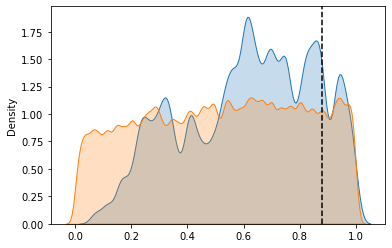

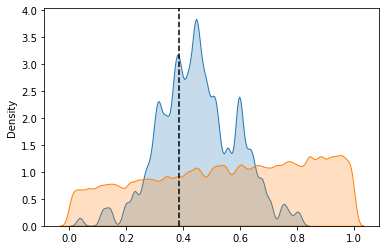

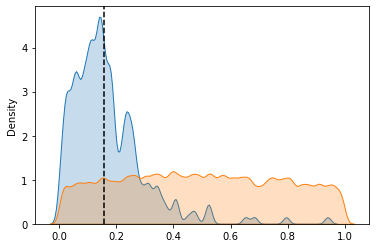

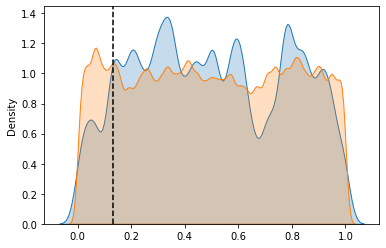

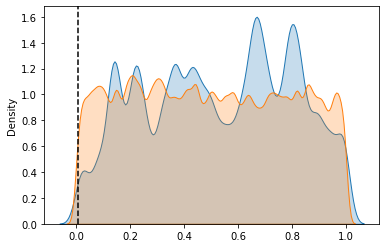

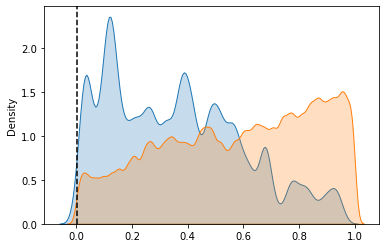

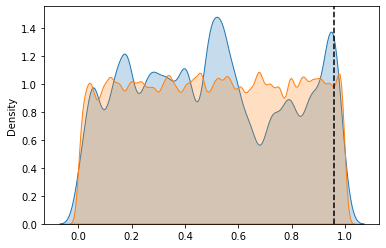

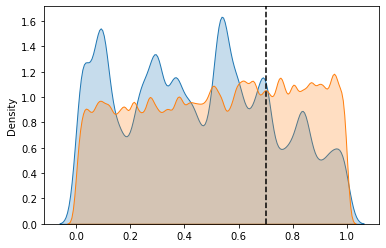

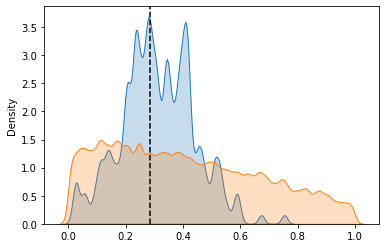

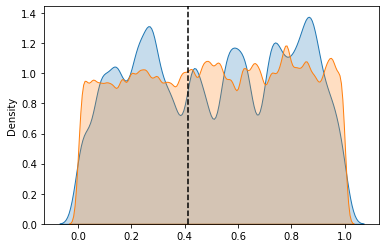

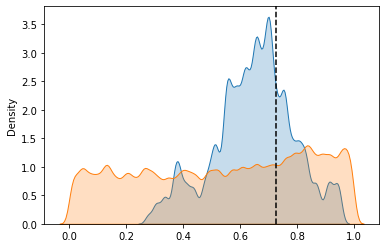

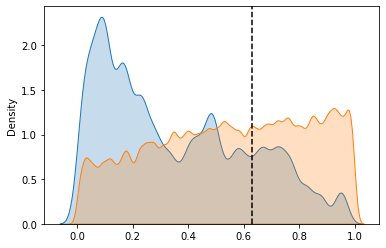

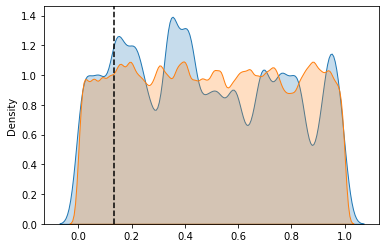

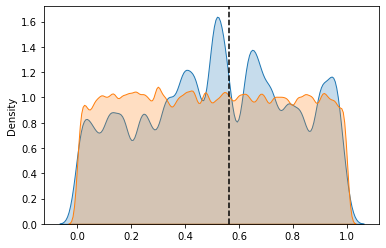

In [109]:
for i in range(18):
    sns.kdeplot(y_m_1[:,i], fill=True, bw_adjust=0.25, label = 'Surrogate model');
    sns.kdeplot(y_m_2[:10000,i], fill=True, bw_adjust=0.25, label = 'Surrogate model');
    plt.axvline(x=y_t[i], color='k', linestyle='--', label = 'true value')
    plt.show()

In [155]:
from scipy.stats import wasserstein_distance

In [157]:
from scipy.stats import wasserstein_distance

def wd_batch(x, y):
    xi = []
    for i in range(18):
        xi.append(wasserstein_distance(y_s[:,i], y_m[:,i]))
    return xi

In [187]:
xi = []
for eps in np.arange(5e-2, 1., 0.05):
    y_s = y_s_[np.array(diff_s) < eps]
    y_m = y_m_[np.array(diff_m) < eps]
    xi.append(wd_batch(y_s, y_m))

In [194]:
cols = ['delta', 'beta', 'thickness','roughness', 'hurst', 'corrlen']

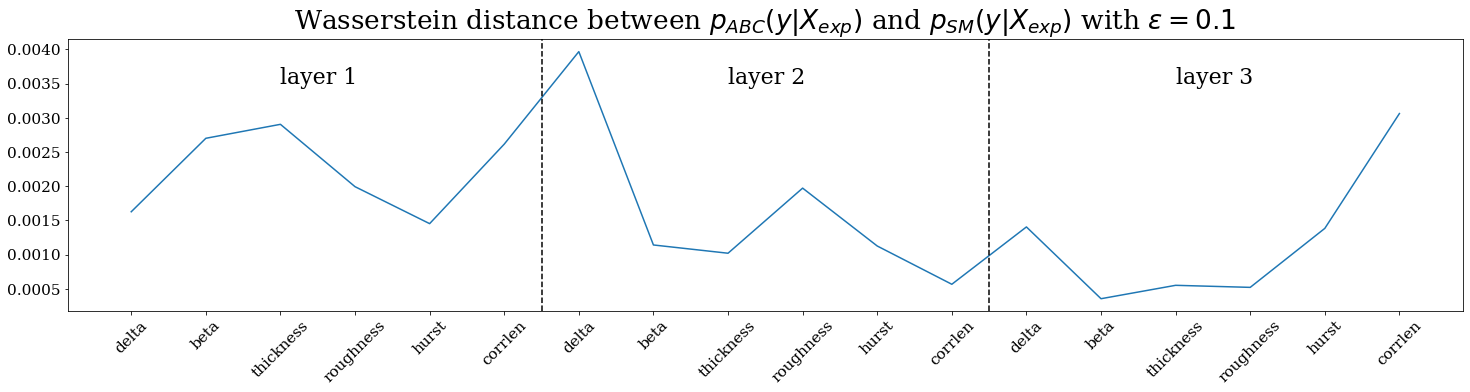

In [214]:
plt.figure(figsize = (25,5))
plt.plot(np.array(xi)[1,:])
plt.title(r'Wasserstein distance between $p_{ABC}(y|X_{exp})$ and $p_{SM}(y|X_{exp})$ with $\epsilon = 0.1$')
ax = plt.gca()
plt.xticks(np.arange(0, 18, 1.0))
plt.axvline(x=5.5, color='k', linestyle='--', label = 'true value')
plt.axvline(x=11.5, color='k', linestyle='--', label = 'true value')
ax.set_xticklabels(cols*3, rotation=45)
plt.text(2,0.0035, 'layer 1')
plt.text(8,0.0035, 'layer 2')
plt.text(14,0.0035, 'layer 3')

plt.show()

Text(0, 0.5, 'Wasserstein distance')

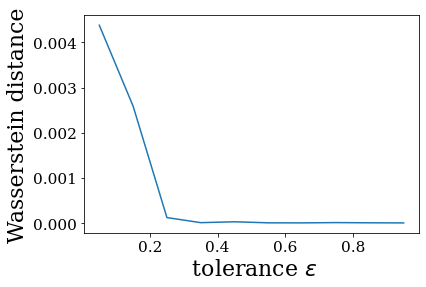

In [181]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

plt.plot(np.arange(5e-2, 1., 0.1), np.array(xi)[:,1])
plt.xlabel(r' tolerance $\epsilon$')
plt.ylabel('Wasserstein distance')

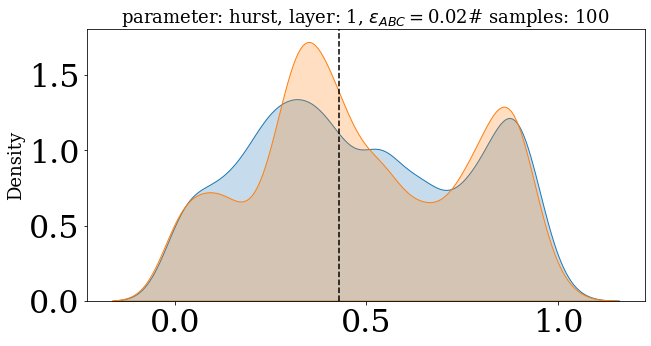

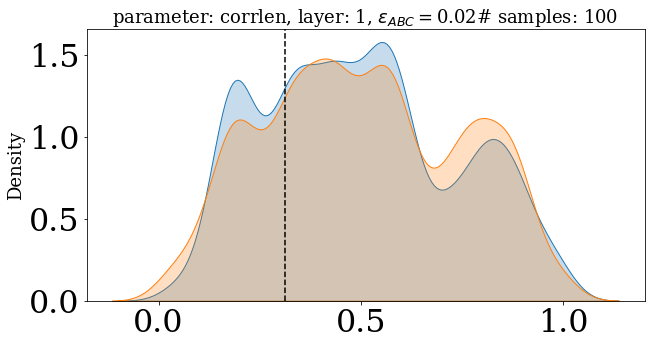

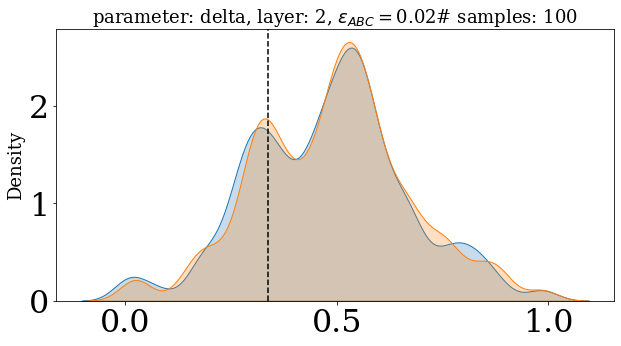

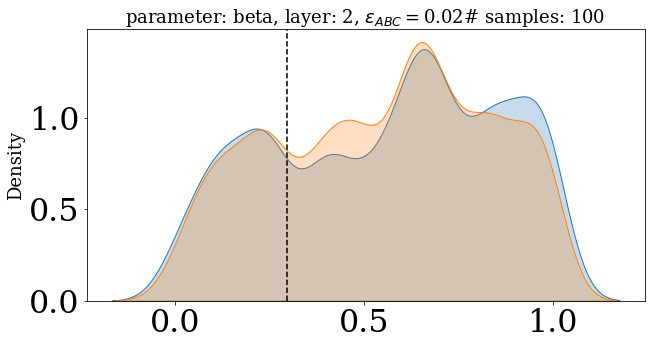

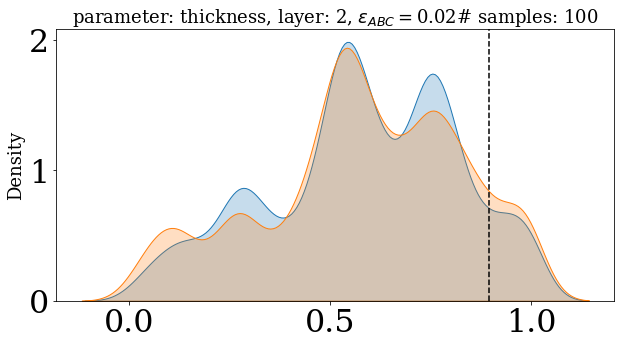

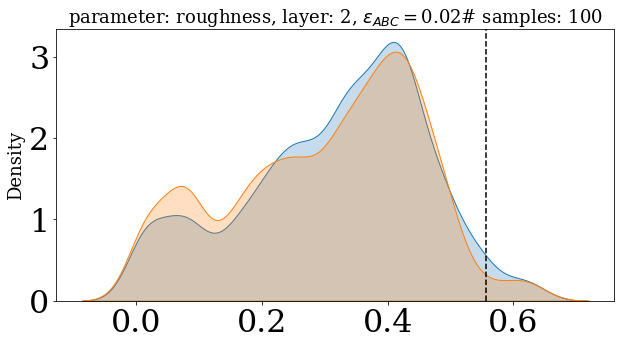

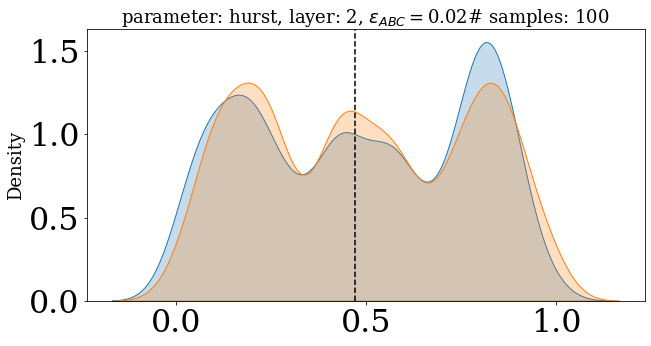

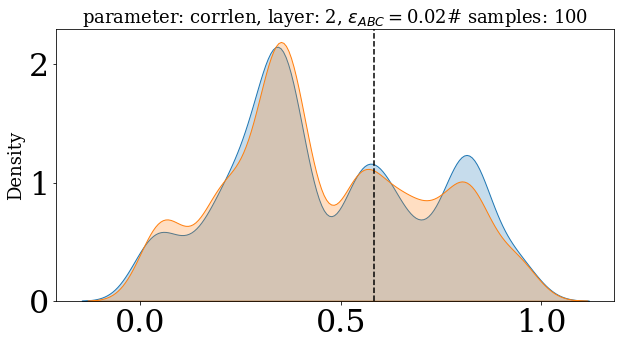

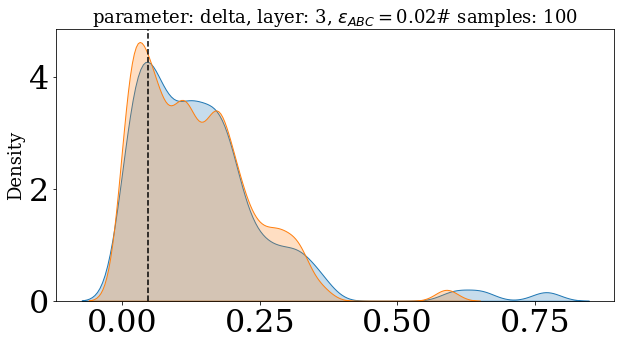

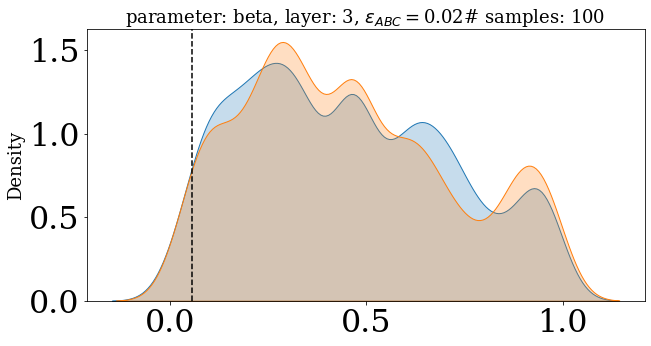

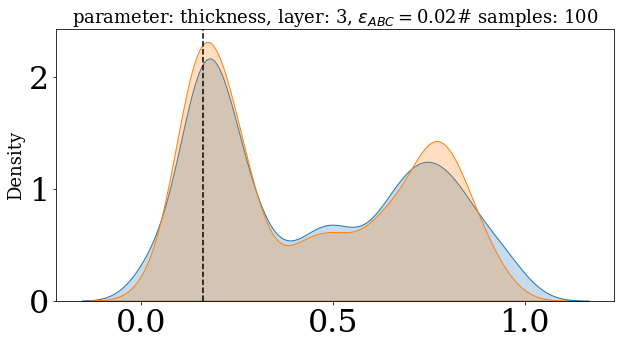

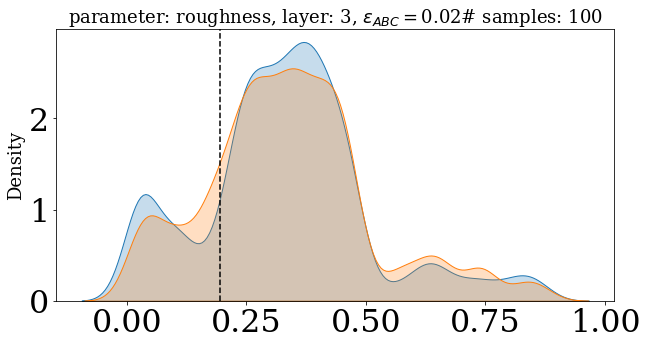

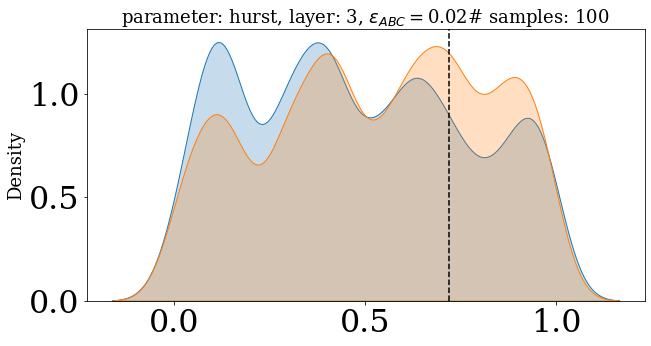

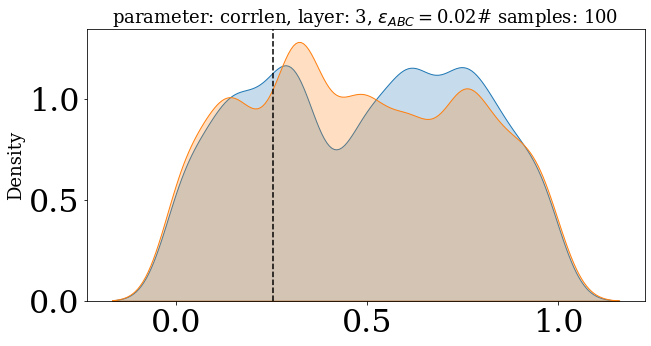

In [104]:
import seaborn as sns

for j in range(3):
    
    fig, ax = plt.subplots(2,3,figsize = [10,5])
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize='x-large')
    plt.rc('ytick', labelsize='x-large')

    for i in range(6):
        parameter = cols[i]
        layer = j + 1

        sns.kdeplot(y_s[:,i], fill=True, bw_adjust=0.5, label = 'BornAgain simulation', ax = ax[i]);
        sns.kdeplot(y_m[:,i], fill=True, bw_adjust=0.5, label = 'Surrogate model', ax = ax[i]);
        plt.axvline(x=y_t[i], color='k', linestyle='--', label = 'true value', ax = ax[i])
        plt.title('parameter: ' + str(parameter) + ', layer: ' + str(layer) +  r', $\epsilon_{ABC} = $' + str(np.round(np.sort(diff_s)[100],2)) + '# samples: 100', fontsize=18)
        plt.ylabel('Density', fontsize=18)
    #plt.legend(fontsize=18, loc = 'upper right')
    plt.show()

## Creating dataset

In [13]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt

from models.convnet import ConvNet
from models.resnet import ResNet

from dataset.ba_dataset import setup_data_loaders
from dataset.preprocessing import Transform

In [18]:
[int(file.split('/')[-1].split('.')[0]) for file in glob('/bigdata/hplsim/aipp/Maksim/BA_simulation/layer_11/*')]

[30716,
 30519,
 822,
 16299,
 2295,
 2584,
 9655,
 15020,
 40856,
 7171,
 100,
 41295,
 5327,
 5616,
 10300,
 11015,
 9287,
 11051,
 20982,
 7674,
 7963,
 40898,
 5190,
 40795,
 30652,
 3635,
 1151,
 8222,
 10515,
 40322,
 690,
 5982,
 3267,
 20899,
 40451,
 41097,
 1654,
 10968,
 41213,
 1943,
 20797,
 6241,
 6530,
 41445,
 2202,
 467,
 15530,
 1286,
 8357,
 8646,
 21259,
 4029,
 4318,
 11290,
 40945,
 15683,
 632,
 15589,
 20641,
 16094,
 6665,
 4181,
 41388,
 40313,
 2337,
 9408,
 2626,
 15657,
 7213,
 40365,
 41231,
 11392,
 5600,
 6297,
 409,
 30024,
 21062,
 20800,
 4973,
 10414,
 40607,
 9560,
 83,
 16135,
 7716,
 11458,
 5232,
 10062,
 30048,
 9192,
 2992,
 7348,
 40108,
 999,
 3251,
 3540,
 277,
 9695,
 9984,
 5367,
 5656,
 10189,
 1328,
 16081,
 30534,
 942,
 442,
 10924,
 31076,
 11183,
 3675,
 40769,
 3964,
 1191,
 8262,
 8551,
 6707,
 4223,
 10257,
 219,
 2610,
 15239,
 1983,
 6339,
 41129,
 6570,
 4726,
 40347,
 2242,
 9313,
 9602,
 15205,
 11315,
 15596,
 8397,
 41186,


In [ ]:
n_samples = 10000
batch_size = 100
pin_memory = False
num_workers = 0
path = '/bigdata/hplsim/aipp/Maksim/BA_simulation/layer_3_easy/'
preload = True
val_frac = .01

transformation = Transform(True, True, True)
loaders = setup_data_loaders(path, n_samples, batch_size, transform=transformation, val_frac = val_frac, preload=preload, num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
plt.imshow(loaders['train'].dataset[3][0].squeeze())
plt.colorbar()

In [34]:
t = [1.32, 2.21, 3.45, 4.81, 6.25, 7.93]
n = [1,3,5,7,9,11]

In [36]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Simulating 50k samples')

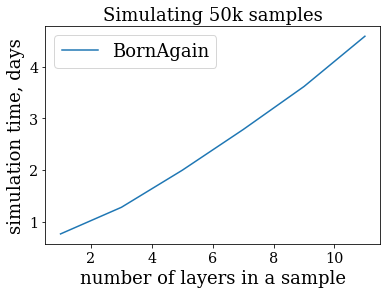

In [41]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

plt.plot(n, np.array(t)*50000/3600/24, label = 'BornAgain')
plt.xlabel('number of layers in a sample', fontsize = 18)
plt.ylabel('simulation time, days', fontsize = 18)
plt.legend(fontsize = 18)
plt.title('Simulating 50k samples', fontsize = 18)